# Анализ сервиса аренды самокатов

**Цель исследования:** Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Описание проекта:** Сервис аренды самокатов GoFast собрал данные о поездках своих клиентов. Чтобы совершать поездки по городу, пользователи GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки
    * абонентская плата отсутсвует;
    * стоимость одной минуты поездки - 88 рублей;
    * стоимость старта (начала поездки) - 50 рублей;
* с подпиской Ultra
    * абонентска плата - 199 рублей в месяц;
    * стоимость одной минуты поездки - 66 рублей;
    * стоимость старта - бесплатно
     
**Описание данных:**

У нас есть три датасета:
* с данными о пользователях;
* с данными о поездках;
* с данными о подписках

**Ход исследования:**
1. Подготовка данных: загрузка и изучение общей информации о датасете;
2. Предобработка данных: приведение к верному типу данных, добавление новых признаков, обработка пропущенных значений и дубликатов;
3. Исследовательский анализ данных: визуализация общей информации о пользователях и поездках;
4. Объединение и расширение данных;
5. Подсчет выручки;
6. Проверка гипотез;
7. Распределения.

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

С помощью данного анализа мы изучим, насколько отличается среднее время поездки и расстояние для пользователей с подпиской и без. Результаты исследования помогут нам понять, какие пользователи наиболее выгодны для бизнеса и какие цели можно будет поставить, чтобы бизнес вырос.

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from math import sqrt

## 1. Подготовка данных

### Загрузим CSV-файлы с данными

In [2]:
#Данные о пользователях
users_data = pd.read_csv('users_go.csv')

In [3]:
#Данные о поездках
rides_data = pd.read_csv('rides_go.csv', parse_dates=['date'])

In [4]:
#Данные о подписках
subscriotions_data = pd.read_csv('subscriptions_go.csv')

### Выведем первые строки каждого датасета и изучим общую информацию

In [5]:
def data_characteristics(df):
    return display(df.head(10), df.info())

In [6]:
#Данные о пользователях
data_characteristics(users_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


None

В датасете о пользователях есть следующие столбцы:
- user_id - уникальный индентификатора пользователя
- name - имя пользователя
- age - возраст пользователя
- city - город
- subscription_type - тип подписки (free, ultra)
  
В датасете 18068 строк, 5 столбцов. Названия столбцов записаны корректно. Пропусков в данных нет. Типы данных указаны корректно.

In [7]:
#Данные о поездках
data_characteristics(rides_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


None

В датасете о поездках есть следующие столбцы:
- user_id - уникалальный индентификатора пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) - время с того момента, как пользователь нажал кнопку "Начать поездку" до момента, как он нажал кнопку "Завершить поездку"
- date - дата совершения поездки
  
В датасете 18068 строк, 4 столбца. Названия столбцов записаны корректно. Пропусков в данных нет. Типы данных указаны корректно.

In [8]:
#Данные о подписках
data_characteristics(subscriotions_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


None

В датасете о подписках есть следующие столбцы:
- subscription_type   - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

В датасете 2 строки, 4 столбца. Названия столбцов записаны корректно. Пропусков в данных нет. Типы данных указаны корректно.

## Предобработка данных

### Создание новых признаков

Создадим новый столбец с номером месяца на основе столбца `date`

In [9]:
rides_data['month'] = pd.DatetimeIndex(rides_data['date']).month

### Обработка пропущенных значений

In [10]:
# Проверим наличие пропущенных значений в данных о пользователях
users_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

В данных о пользователях пропусков нет.

In [11]:
# Проверим наличие пропущенных значений в данных о поездках
rides_data.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

В данных о поездках пропусков нет.

In [12]:
# Проверим наличие пропущенных значений в данных о подписках
subscriotions_data.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

В данных о подписках пропусков нет.

### Обработка дубликатов

Проверим наличие явных дубликатов в столбце `user_id` датасета users_data

In [13]:
users_data['user_id'].duplicated().sum()

31

В столбце `user_id` датасета users_data 31 явный дубликат. Удалим их.

In [14]:
users_data = users_data.drop_duplicates()

Проверим наличие явных дубликатов в датасете rides_data

In [15]:
rides_data.duplicated().sum()

0

Явных дубликатов нет

В датасете subscriptions_data всего две строки, дубликатов там нет.

**Вывод:** Я произвела предобработку данных:
- cоздала новый столбец с номером месяца на основе столбца `date`, он понадобится для будующих исследований;
- пропусков в данных обнаружено не было;
- все явные дубликаты удалены.

In [16]:
#Проверим, за какой период у нас данные
rides_data['date'].min(), rides_data['date'].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-12-30 00:00:00'))

Данные представлены с 01 января 2021 года по 30 декабря 2021 года

In [17]:
#Округлим расстояния методом round()
rides_data['distance'] = rides_data['distance'].round(0)

## Исследовательский анализ данных

### Частота встречаемости городов

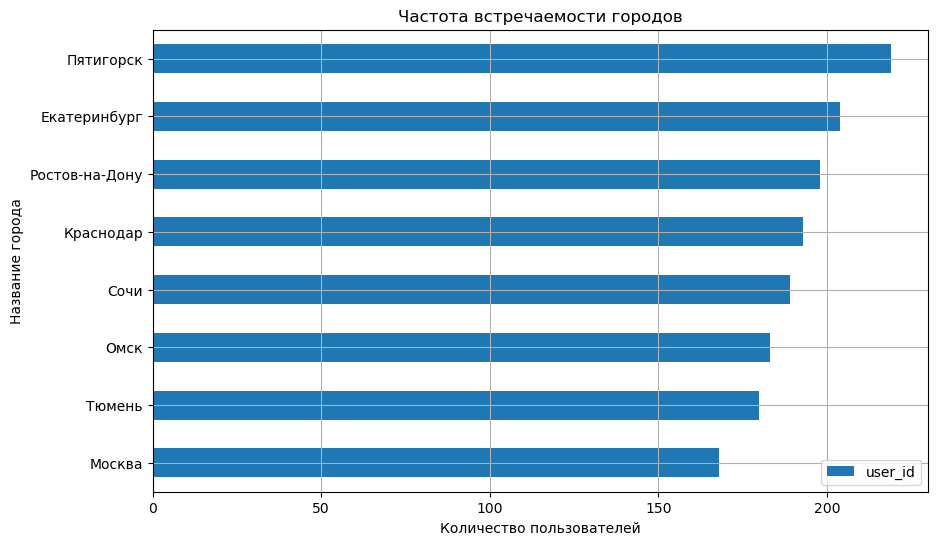

In [18]:
#Построим столбчатую диаграмму
users_data.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=True).plot(kind='barh', grid=True, figsize=(10, 6))
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Название города')
plt.show()

In [19]:
# Выведем таблицу с числовыми значениями частотности городов
users_data.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


По графику видно, что больше всего пользователей из Пятигорска, на втором и третьем местах Екатеринбург и Ростов-на-Дону, последнее место занимает Москва.

### Соотношение пользователей с подпиской и без подписки

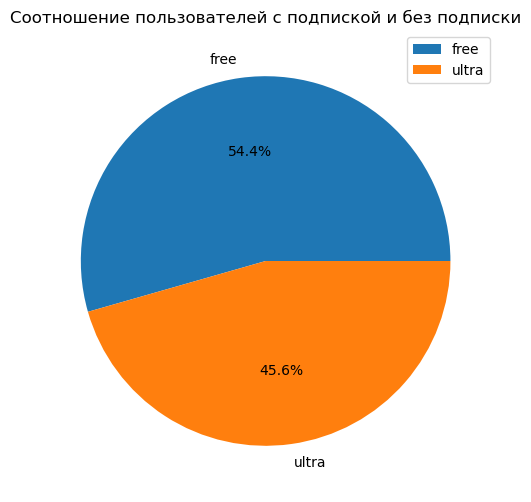

In [20]:
#Построим круговую диаграмму
users_data.pivot_table(index='subscription_type', values='user_id', aggfunc='count').plot(kind='pie', y='user_id', autopct='%1.1f%%', figsize=(10,6))
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.xlabel(None)
plt.ylabel(None)
plt.show()

На графике мы видим, что 54,4% пользователей пользуются самокатами без подписки, а 45,6% с подпиской.

### Возраст пользователей

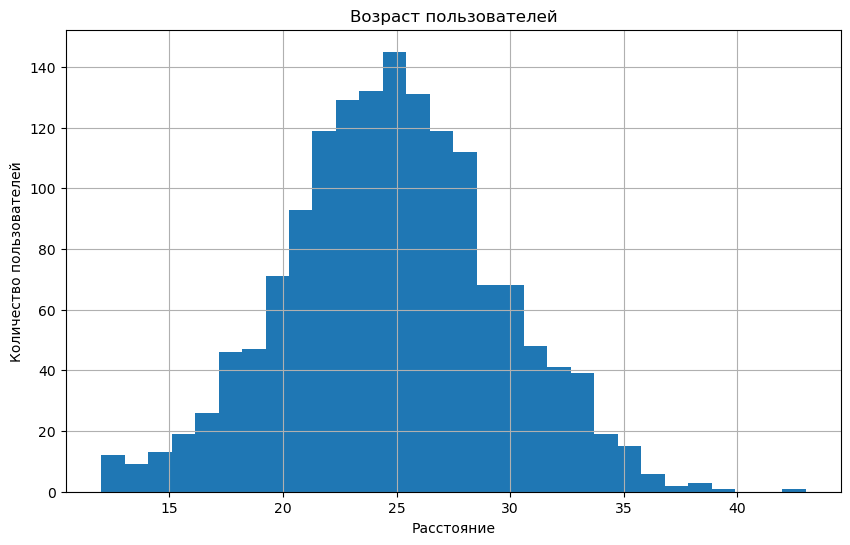

In [21]:
#Построим гистограмму
users_data['age'].hist(figsize=(10,6), bins=30)
plt.title('Возраст пользователей')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')
plt.show()

In [22]:
# выведем описательную статистику
users_data['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

На графике мы видим, что возраст большинства пользователей от 20 до 30 лет (75% пользоватлей в возрасте до 28 лет), средний возраст - 25 лет. Также мы видим несколько совсем молодых пользователей в возрасте 12 лет, и несколько в возрасте 43 лет. Это максимальный возраст.

### Расстояние, которое пользователь преодолел за одну поездку

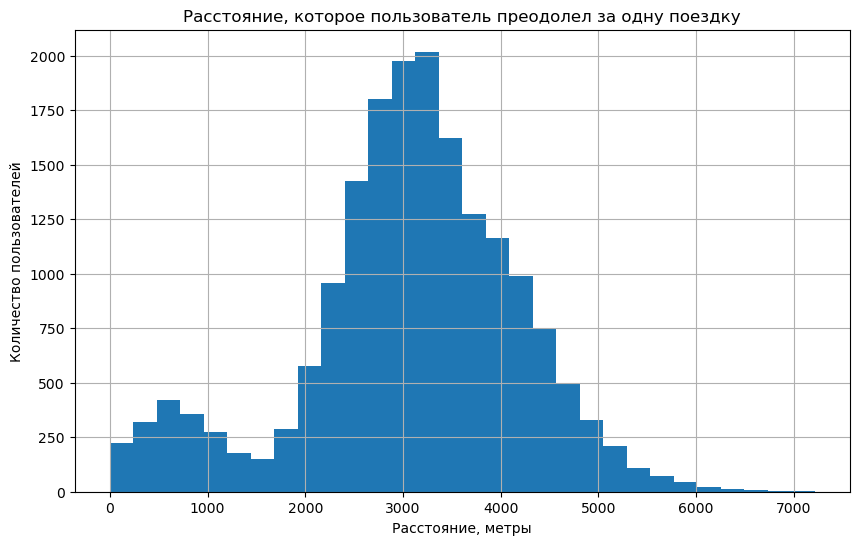

In [23]:
#Построим гистограмму
rides_data['distance'].hist(figsize=(10,6), bins=30)
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, метры')
plt.ylabel('Количество пользователей')
plt.show()

In [24]:
# выведем описательную статистику
rides_data['distance'].describe()

count    18068.000000
mean      3070.659010
std       1116.832209
min          1.000000
25%       2543.000000
50%       3134.000000
75%       3776.000000
max       7211.000000
Name: distance, dtype: float64

На данном графике мы видим, что среднее расстояние, которое проехало большинство пользователей составляет 3 километра, максимальное - 7 км, минимальное -  меньше метра, возвомжно в этих случаях пользователи передумали бронировать самокат. Так же мы видим небольшой скачок на пятистах метрах. Большинство поездок (75%) все же составляют до 3,7 км.

### Продолжительность поездок

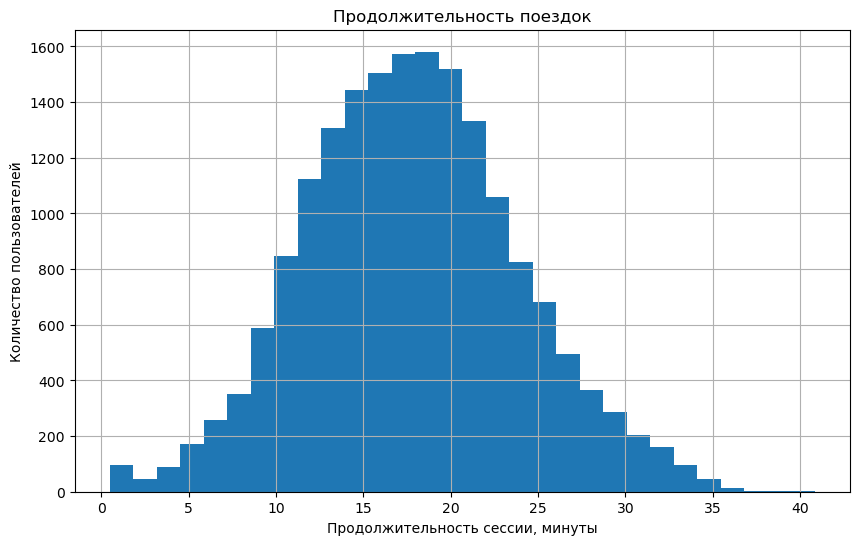

In [25]:
#Построим гистограмму
rides_data['duration'].hist(figsize=(10,6), bins=30)
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность сессии, минуты')
plt.ylabel('Количество пользователей')
plt.show()

In [26]:
# выведем описательную статистику
rides_data['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

На графике видно, что в основном длительность поездок находится в диапазоне от 13 до 21 минуты. Есть очень длинные поездки, например, самое длинное время бронирования 40 минут, но таких мало. А также очень короткие: меньше минуты. Возможно пользователь передумал бронировать самокат. В целом график имеет нормальное распределение и данные кажутся адекватными.

**Вывод:** Я провела исследовательский анализ данных и выяснила следующее:
- Больше всего пользователей из Пятигорска, на втором и третьем местах Екатеринбург и Ростов-на-Дону, последнее место занимает Москва;
- 54,4% пользователей пользуются самокатами без подписки, а 45,6% с подпиской;
- Возраст большинства пользователей от 20 до 30 лет. Есть несколько совсем молодых пользователей в возрасте 7 лет, а также в возрасте 43 лет. Это максимальный возраст;
- Cреднее расстояние, которое проехало большинство пользователей составляет 3 километра, максимамальное - 7 км, минимальное - меньше метра, возможно в этих случаях пользователи передумали бронировать самокат. Так есть небольшой скачок на пятистах метрах. Большинство поездок (75%) все же составляют до 3,7 км;
- В основном длительность поездок находится в диапазоне от 13 до 21 минуты. Есть очень длинные поездки, например, самое длинное время бронирования 40 минут, но таких мало. А также очень короткие: меньше минуты. Возможно пользователь передумал бронировать самокат. 

В целом графики имеют нормальное распределение и данные кажутся адекватными.

## Объединение данных

### Объединим данные о пользователях, поездках и подписках в один датасет

Перед объединением проверим исходную размерность датасетов

In [27]:
users_data.shape

(1534, 5)

In [28]:
rides_data.shape

(18068, 5)

In [29]:
subscriotions_data.shape

(2, 4)

In [30]:
merge_data = pd.merge(users_data, rides_data, on='user_id')

In [31]:
merge_data = merge_data.merge(subscriotions_data, on='subscription_type')

In [32]:
merge_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410.0,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618.0,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.0,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695.0,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029.0,26.265803,2021-08-28,8,6,0,199


Проверим размерность таблицы после присоединения

In [33]:
merge_data.shape

(18068, 12)

Размерность объединенной таблицы совпадает с исходной

In [34]:
#Проверим объединенный датасет на пропуски
merge_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков в объединенном датасете нет

### Создадим два датафрейма на основе полученного датасета

**Датасет с данными о пользователях без подписки**

In [35]:
data_free = merge_data[merge_data['subscription_type']=='free']
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2516.0,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,847.0,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.0,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1206.0,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.0,17.427673,2021-02-14,2,8,50,0


**Датасет с данными о пользователях с подпиской**

In [36]:
data_ultra = merge_data[merge_data['subscription_type']=='ultra']
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410.0,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618.0,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.0,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695.0,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029.0,26.265803,2021-08-28,8,6,0,199


### Визуализируем информацию о расстоянии и времени поездки для пользователей обеих категорий

**Расстояние, которое преодолели пользователя за одну поездку для пользователей с подпиской и без**

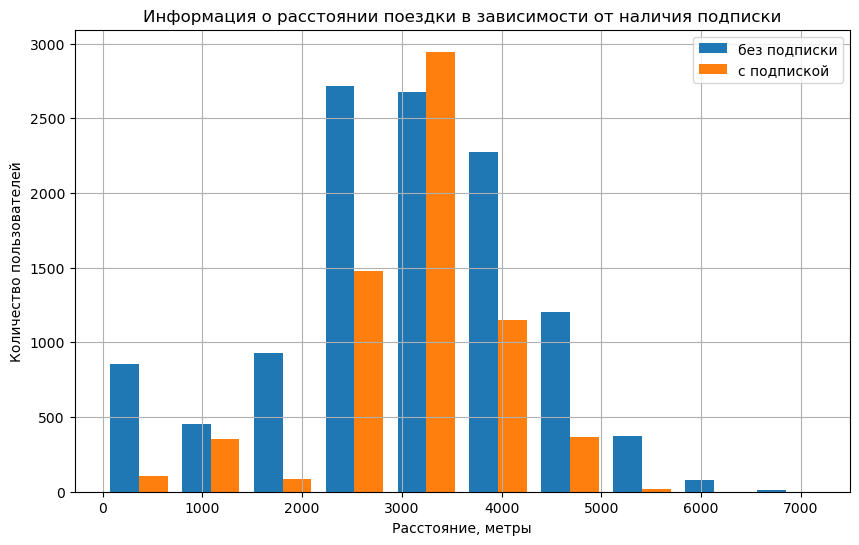

In [37]:
names = ['без подписки', 'с подпиской']
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.hist([data_free['distance'], data_ultra['distance']], label=['без подписки', 'с подпиской'])
plt.legend()
plt.title('Информация о расстоянии поездки в зависимости от наличия подписки')
plt.xlabel('Расстояние, метры')
plt.ylabel('Количество пользователей')
plt.show()

На графике мы видим, что поездки длиной 3 км совершались больше пользователями с подписком, чем без, на рассотяние больше 5 километров пользователи с подпиской вообще не ездят. Также пользователи с подпиской значительно реже ездят на расстояния до 3 км, чем пользователи без подписки и редко отменяют бронирование в самом начале.

**Время в пути для пользователей с подпиской и без**

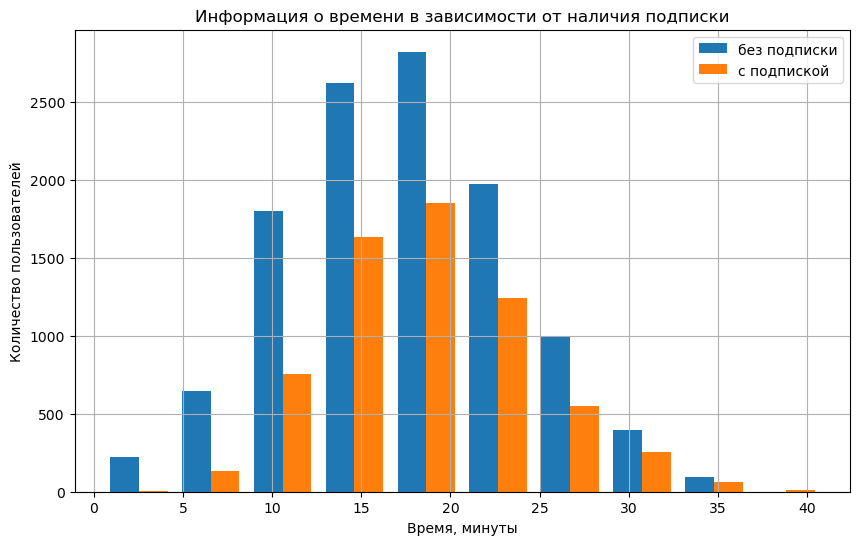

In [38]:
names = ['без подписки', 'с подпиской']
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.hist([data_free['duration'], data_ultra['duration']], label=['без подписки', 'с подпиской'])
plt.legend()
plt.title('Информация о времени в зависимости от наличия подписки')
plt.xlabel('Время, минуты')
plt.ylabel('Количество пользователей')
plt.show()

Время в пути для пользователей с подпиской и без подписки распределно равномерно.

## Подсчёт выручки

### Создадим датасет с аггрегированными данными о поездках

In [39]:
revenue_data = merge_data.pivot_table(index = ['user_id', 'month', 'subscription_type'], values = ['distance', 'duration','minute_price', 'start_ride_price', 'subscription_fee'], aggfunc = ({'distance':{'count', 'sum'}, 'duration':'sum', 'minute_price': 'mean', 'start_ride_price': 'mean', 'subscription_fee':'mean'}))
revenue_data.columns = ['count', 'distance_sum', 'duration_sum', 'minute_price', 'start_ride_price', 'subscription_free']
revenue_data.head(10)

count  distance_sum  duration_sum  \
user_id month subscription_type                                      
1       1     ultra                  2        7028.0     41.416640   
        4     ultra                  1         754.0      6.232113   
        8     ultra                  2        6724.0     44.776802   
        10    ultra                  2        5810.0     31.578017   
        11    ultra                  3        7004.0     53.397424   
        12    ultra                  2        6752.0     27.203912   
2       3     ultra                  3       10188.0     60.959959   
        4     ultra                  2        6165.0     39.048633   
        6     ultra                  1        3255.0     13.851127   
        7     ultra                  2        6781.0     46.170157   

                                 minute_price  start_ride_price  \
user_id month subscription_type                                   
1       1     ultra                       6.0               0.0   
        4     ultra                       6.0               0.0   
        8     ultra                       6.0               0.0   
        10    ultra                       6.0               0.0   
        11    ultra                       6.0               0.0   
        12    ultra                       6.0               0.0   
2       3     ultra                       6.0               0.0   
        4     ultra                       6.0               0.0   
        6     ultra                       6.0               0.0   
        7     ultra                       6.0               0.0   

                                 subscription_free  
user_id month subscription_type                     
1       1     ultra                          199.0  
        4     ultra                          199.0  
        8     ultra                          199.0  
        10    ultra                          199.0  
        11    ultra                          199.0  
        12    ultra                          199.0  
2       3     ultra                          199.0  
        4     ultra                          199.0  
        6     ultra                          199.0  
        7     ultra                          199.0

In [40]:
revenue_data['duration_sum'] = np.ceil(revenue_data['duration_sum'])

### Добавим столбец с помесячной выручкой, которую принес каждый пользователь

In [41]:
revenue_data['revenue'] = revenue_data['start_ride_price'] * revenue_data['count'] + revenue_data['minute_price'] * revenue_data['duration_sum'] + revenue_data['subscription_free']
revenue_data.head(10)

count  distance_sum  duration_sum  \
user_id month subscription_type                                      
1       1     ultra                  2        7028.0          42.0   
        4     ultra                  1         754.0           7.0   
        8     ultra                  2        6724.0          45.0   
        10    ultra                  2        5810.0          32.0   
        11    ultra                  3        7004.0          54.0   
        12    ultra                  2        6752.0          28.0   
2       3     ultra                  3       10188.0          61.0   
        4     ultra                  2        6165.0          40.0   
        6     ultra                  1        3255.0          14.0   
        7     ultra                  2        6781.0          47.0   

                                 minute_price  start_ride_price  \
user_id month subscription_type                                   
1       1     ultra                       6.0               0.0   
        4     ultra                       6.0               0.0   
        8     ultra                       6.0               0.0   
        10    ultra                       6.0               0.0   
        11    ultra                       6.0               0.0   
        12    ultra                       6.0               0.0   
2       3     ultra                       6.0               0.0   
        4     ultra                       6.0               0.0   
        6     ultra                       6.0               0.0   
        7     ultra                       6.0               0.0   

                                 subscription_free  revenue  
user_id month subscription_type                              
1       1     ultra                          199.0    451.0  
        4     ultra                          199.0    241.0  
        8     ultra                          199.0    469.0  
        10    ultra                          199.0    391.0  
        11    ultra                          199.0    523.0  
        12    ultra                          199.0    367.0  
2       3     ultra                          199.0    565.0  
        4     ultra                          199.0    439.0  
        6     ultra                          199.0    283.0  
        7     ultra                          199.0    481.0

Посчитали помесячную выручку, которую принес каждый пользователь

## Проверка гипотез

### Проверим, тратят ли пользователи с подпиской больше времени на поездки

H0: Среднее время поездки у пользователей с подпиской такое же, как у пользователей без подписки.

H1: Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.

In [42]:
alpha = 0.05
duration_user_free = data_free['duration']
duration_user_ultra = data_ultra['duration']
results = st.ttest_ind( duration_user_ultra, duration_user_free, alternative='greater')
print('P-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


У нас есть достаточно оснований утверждать, что среднее время у пользователей с подпиской больше, чем у пользователей без подписки.

### Проверим, превышает ли среднее расстояние, которое проезжают пользователи с подпиской 3130 метров

H0: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров.

H1: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку больше 3130 метров.

In [43]:
optimal_distance = 3130
alpha = 0.05
results = st.ttest_1samp(data_ultra['distance'], optimal_distance, alternative='greater')
print('P-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-значение: 0.9195649894697724
Не получилось отвергнуть нулевую гипотезу


Следовательно у нас недостаточно оснований полагать, что пользователи с подпиской проезжают расстояние больше оптимального.

##### Проверим, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [44]:
revenue_data_free = revenue_data[revenue_data['subscription_free']==0]
revenue_data_free.head()

count  distance_sum  duration_sum  \
user_id month subscription_type                                      
700     1     free                   1        2516.0          15.0   
        2     free                   5       13446.0          86.0   
        3     free                   1        3798.0          19.0   
        4     free                   1        2985.0          16.0   
        6     free                   2        5928.0          29.0   

                                 minute_price  start_ride_price  \
user_id month subscription_type                                   
700     1     free                        8.0              50.0   
        2     free                        8.0              50.0   
        3     free                        8.0              50.0   
        4     free                        8.0              50.0   
        6     free                        8.0              50.0   

                                 subscription_free  revenue  
user_id month subscription_type                              
700     1     free                             0.0    170.0  
        2     free                             0.0    938.0  
        3     free                             0.0    202.0  
        4     free                             0.0    178.0  
        6     free                             0.0    332.0

In [45]:
revenue_data_ultra = revenue_data[revenue_data['subscription_free']==199]
revenue_data_ultra.head()

count  distance_sum  duration_sum  \
user_id month subscription_type                                      
1       1     ultra                  2        7028.0          42.0   
        4     ultra                  1         754.0           7.0   
        8     ultra                  2        6724.0          45.0   
        10    ultra                  2        5810.0          32.0   
        11    ultra                  3        7004.0          54.0   

                                 minute_price  start_ride_price  \
user_id month subscription_type                                   
1       1     ultra                       6.0               0.0   
        4     ultra                       6.0               0.0   
        8     ultra                       6.0               0.0   
        10    ultra                       6.0               0.0   
        11    ultra                       6.0               0.0   

                                 subscription_free  revenue  
user_id month subscription_type                              
1       1     ultra                          199.0    451.0  
        4     ultra                          199.0    241.0  
        8     ultra                          199.0    469.0  
        10    ultra                          199.0    391.0  
        11    ultra                          199.0    523.0

H0: Помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки.

H1: Помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки.

In [46]:
alpha = 0.05
revenue_user_free = revenue_data_free['revenue']
revenue_user_ultra = revenue_data_ultra['revenue']
results = st.ttest_ind(duration_user_ultra, duration_user_free, alternative='greater')
print('P-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


У нас достаточно оснований полагать, что помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки.

**Вывод:** Я проверила гипотезы и сделала следующие выводы:
- У нас есть достаточно оснований утверждать, что среднее время у пользователей с подпиской больше, чем у пользователей без подписки и, что помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки;
- Недостаточно оснований полагать, что пользователи с подпиской проезжают расстояние больше оптимального;

На основе доступных мне данных у меня достаточно оснований полагать, что пользователи с подпиской выгоднее для компании, так как приносят больше прибыли.

## Распределения

### Выясним, какое минимальное количество промокодов нужно разослать,чтобы вероятность не выполнить план была примерно 5%

Минимальное количество промокодов, которые нужно разослать,чтобы вероятность не выполнить план была примерно 5%: 1161


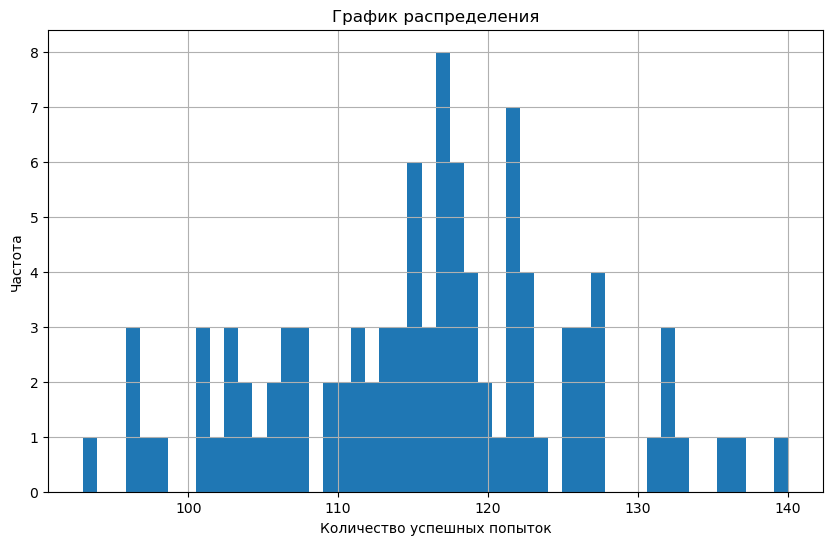

In [47]:
n = 100
p = 0.1
k = 99
alpha = 0.05
while st.binom.cdf(k, n, p) > alpha:
    n+=1
print('Минимальное количество промокодов, которые нужно разослать,чтобы вероятность не выполнить план была примерно 5%:', n)

binom = np.random.binomial(n, p, k)

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.hist(binom, bins=50)
plt.xlabel('Количество успешных попыток')
plt.ylabel('Частота')
plt.title('График распределения')
plt.show()

### Вероятность открытия push-уведомлений

In [48]:
n = 1000000
p = 0.4
k=399500

mu = n*p
sigma = sqrt(n*p*(1-p))

distr = st.norm(mu, sigma)

result = distr.cdf(k)
print(result)

0.15371708296369768


Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей составляет 15%

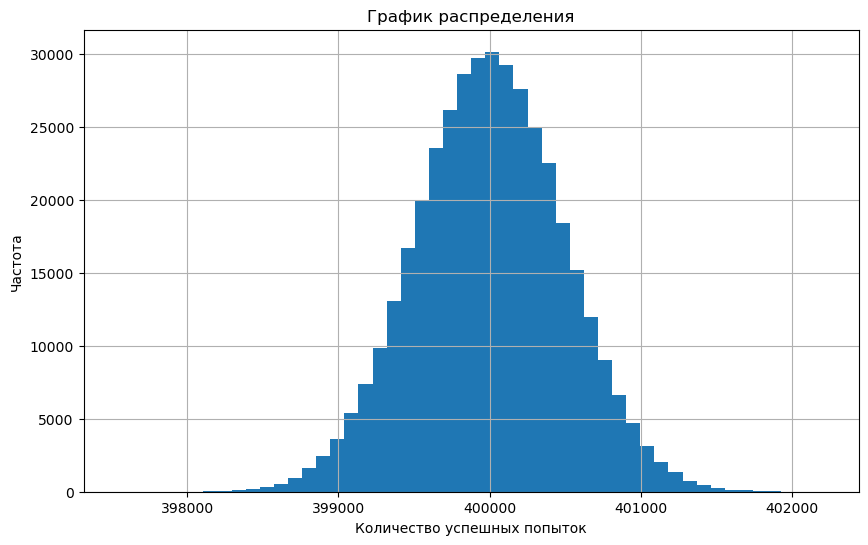

In [49]:
binom = np.random.binomial(n, p, k)

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.hist(binom, bins=50)
plt.xlabel('Количество успешных попыток')
plt.ylabel('Частота')
plt.title('График распределения')
plt.show()

# Вывод
В данном проекте я выполнила следующие шаги:
* **Выполнила предобработку данных.** 
    * Привела столбцы к правильному типу данных;
    * Добавила в датасет новые столбцы, которые мне понадобились для последующего анализа данных;
    * Удалила явные дубликаты;
    * Пропусков в данных нет, их обрабатывать не пришлось
* **Провела исследовательский анализ данных и сделала следующие выводы**
    * Больше всего пользователей в датафрейме из Пятигорска, на втором и третьем местах Екатеринбург и Ростов-на-Дону, последнее место занимает Москва;
    * 54,4% пользователей пользуются самокатами без подписки, а 45,6% с подпиской;
    * Возраст большинства пользователей от 20 до 30 лет. Есть несколько совсем молодых пользователей в возрасте 7 лет, а также в возрасте 43 лет. Это максимальный возраст;
    * Cреднее расстояние, которое проехало большинство пользователей составляет 3 километра, максимамальное - 7 км, минимальное - меньше метра, возможно в этих случаях пользователи передумали бронировать самокат. Так есть небольшой скачок на пятистах метрах. Большинство поездок (75%) все же составляют до 3,7 км;
    * В основном длительность поездок находится в диапазоне от 13 до 21 минуты. Есть очень длинные поездки, например, самое длинное время бронирования 40 минут, но таких мало. А также очень короткие: меньше минуты. Возможно пользователь передумал бронировать самокат
* **Объединина данные в один датафрейм**
* **Сравнила расстояние и время поездки для разных категорий (с подпиской и без)**)
* **Подсчитала помесячную выручку для клиентов разных категрий (с подпиской и без)**
* **Проверила гипотезы и сделала следующие выводы:**
    * У нас есть достаточно оснований утверждать, что среднее время у пользователей с подпиской больше, чем у пользователей без подписки и, что помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки;
    * Недостаточно оснований полагать, что пользователи с подпиской проезжают расстояние больше оптимального;

На основе доступных мне данных у меня достаточно оснований полагать, что пользователи с подпиской выгоднее для компании, так как приносят больше прибыли.
    
Выяснила, что минимальное количество промокодов, которые нужно разослать,чтобы вероятность не выполнить план была примерно 5% - 1161, а также, что вероятность того, что уведомление откроют не более 399,5 тысяч пользователей из миллиона составляет 15% 
   
   На основе проделанной работы могу сказать, что компании необходимо привлекать больше пользователей с подпиской, так как они приносят больше прибыли.